In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from itertools import compress
from sklearn.model_selection import TimeSeriesSplit

In [190]:
data = pd.read_csv("../Data/prepared_data.csv")

In [191]:
data

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,32.625806,23.593548,37.380645,27.251613,2.758065,...,19.784194,4.540323,28.529167,28.526478,28.419355,27.342876,0.390527,0.343621,0.305570,0.424620
9012,MA413,2023,4,2.0,3.0,32.833333,23.786667,37.903333,27.520000,2.563333,...,20.378667,4.632667,28.858889,28.759306,28.444028,27.731250,0.398275,0.348147,0.299015,0.413540
9013,MA413,2023,5,3.0,4.0,32.225806,24.061290,37.435484,28.312903,3.029032,...,18.983226,4.261290,28.559140,28.523656,28.383737,27.991801,0.416329,0.391871,0.301789,0.404790
9014,MA413,2023,6,1.0,1.0,29.463333,22.926667,33.333333,26.320000,6.823333,...,14.725667,3.271000,26.370000,26.618611,27.324167,27.972361,0.454496,0.444658,0.349479,0.399222


In [192]:
def plot_corr_heatmap(data, title):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    plt.title(title, fontsize = 30, x=0.5, y=1.02)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    sns.set(font_scale=1.2) # font size 2
    g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [193]:
print(len(data.columns))
list(data.columns)[:12]

24


['FarmID',
 'year',
 'month',
 'Tiny+Small',
 'Large+Mature',
 'temperature_2m_max',
 'temperature_2m_min',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'precipitation_sum',
 'rain_sum',
 'precipitation_hours']

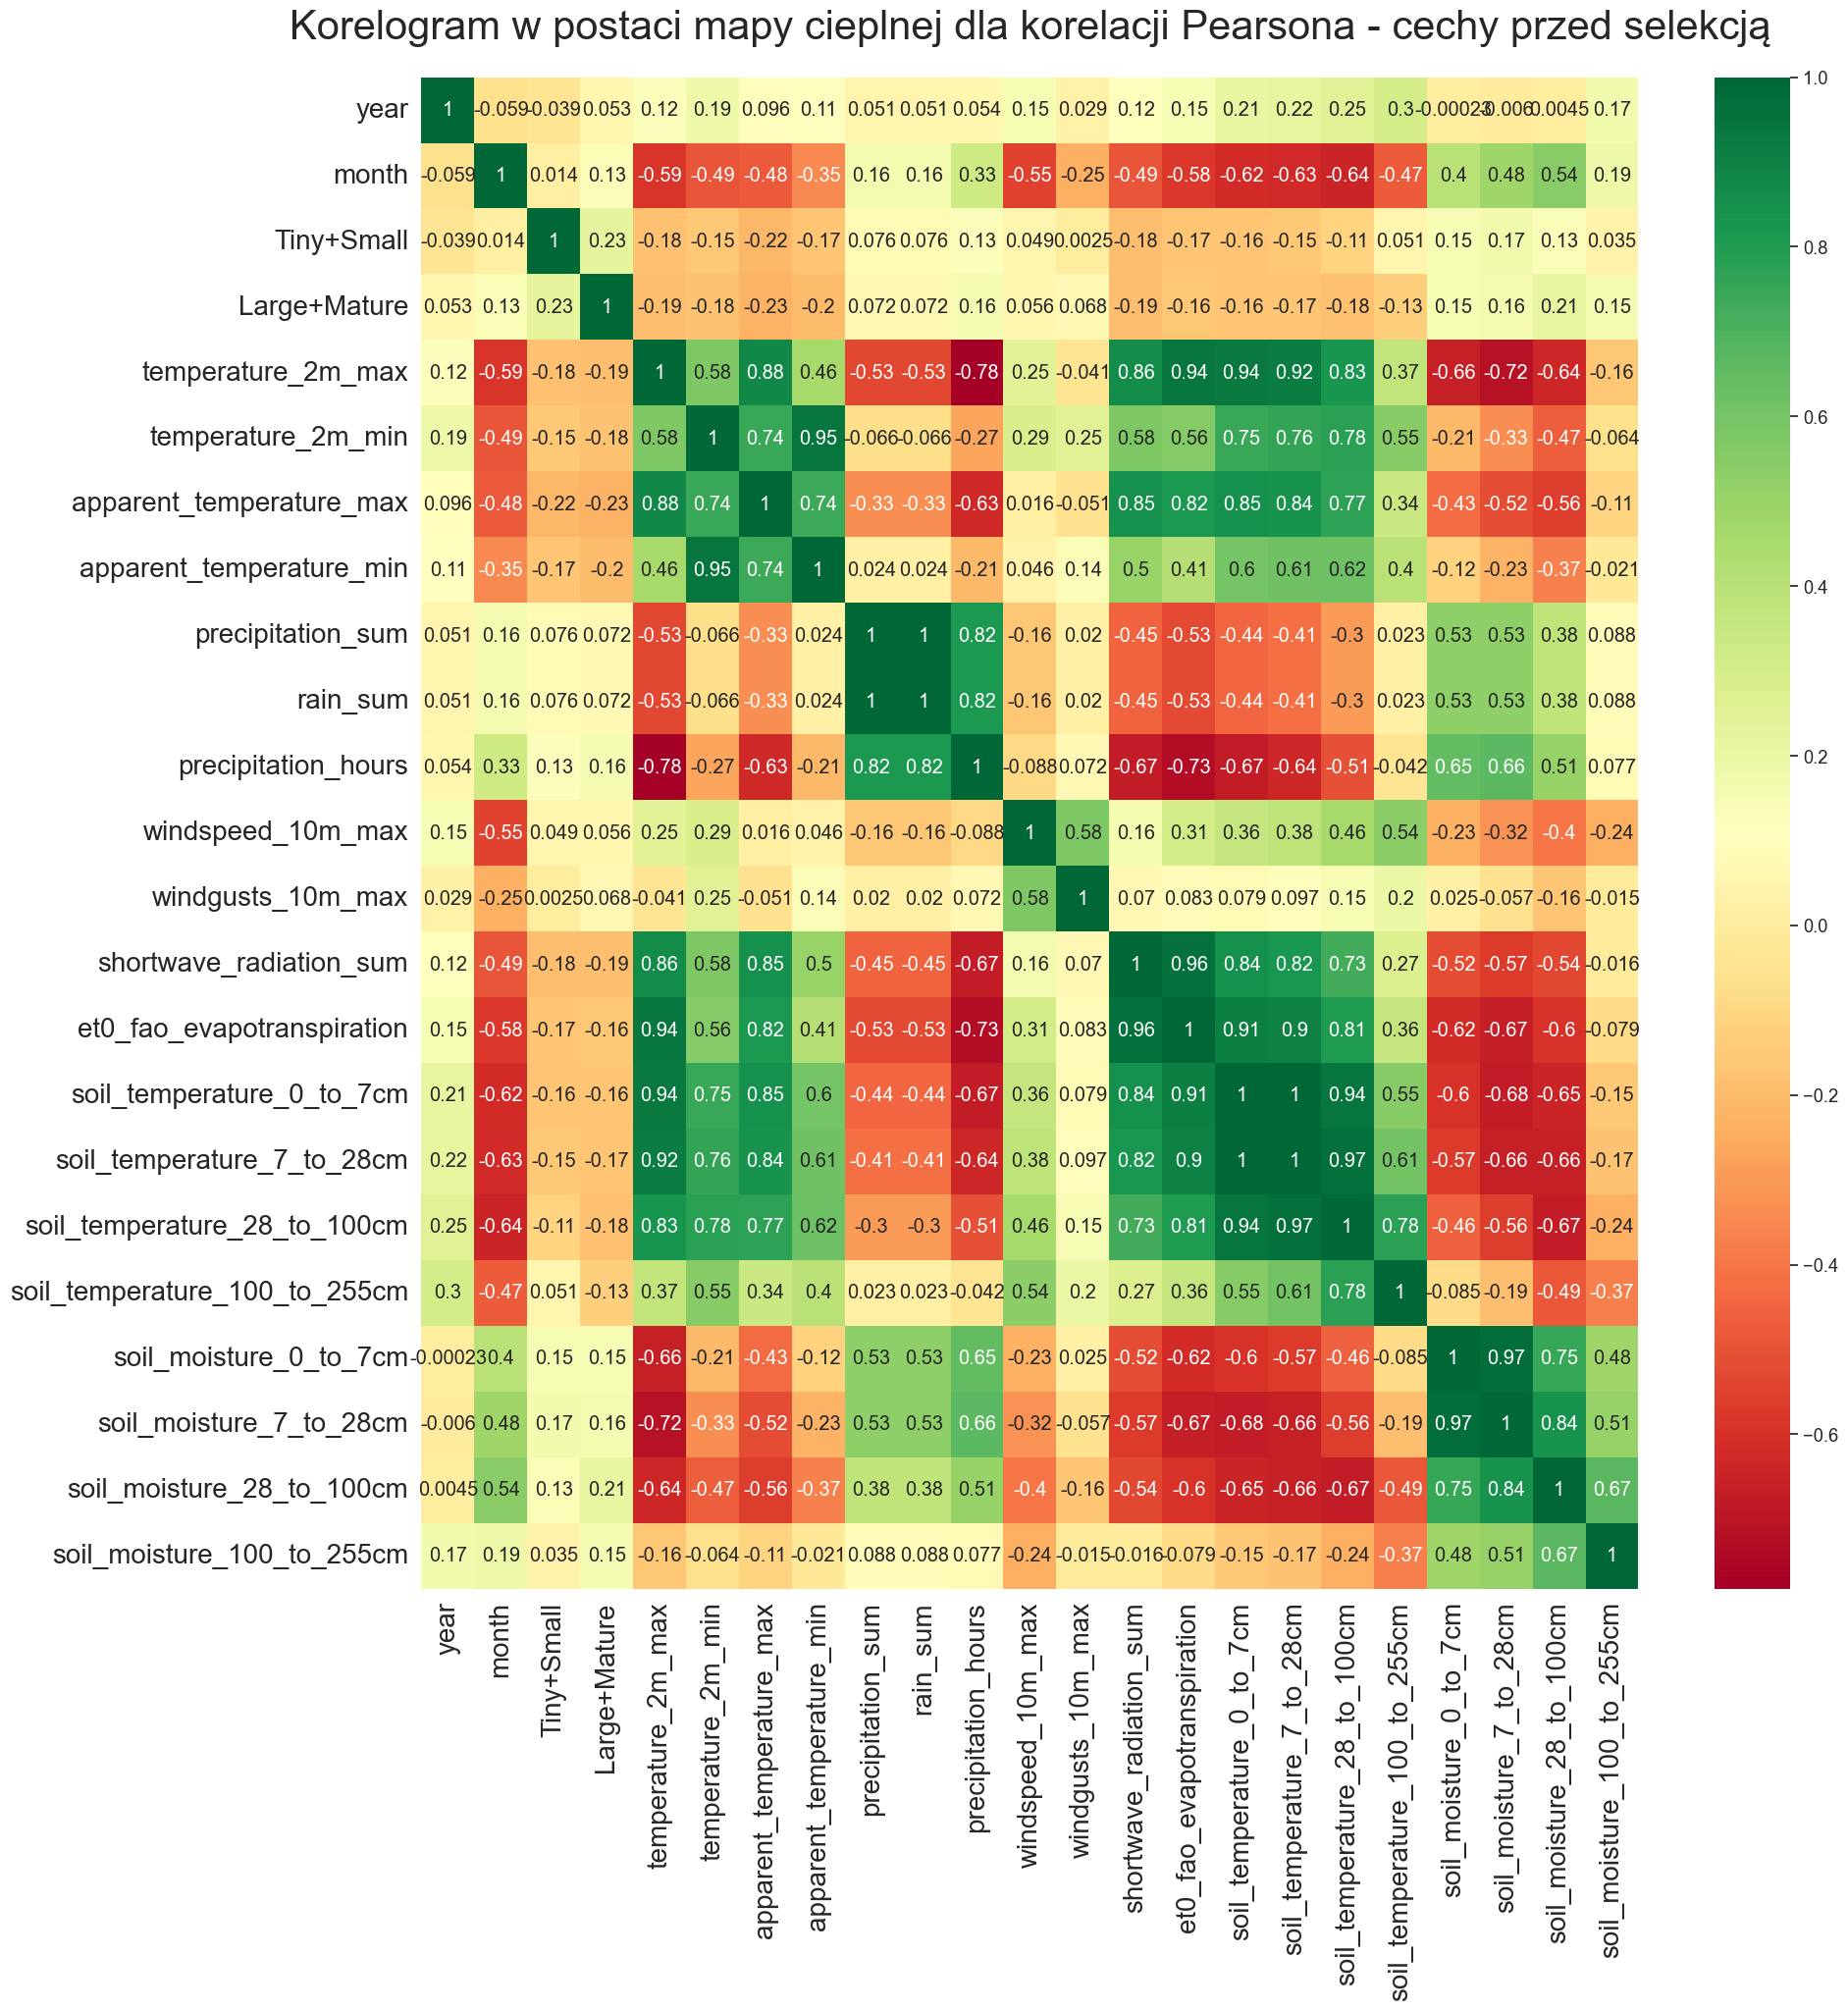

In [194]:
plot_corr_heatmap(data.drop(columns=["FarmID"]), "Korelogram w postaci mapy cieplnej dla korelacji Pearsona - cechy przed selekcją")

What can be removed:

temperature_2m_max <-> et0_fao_evapotranspiration X | soil_temperature_0_to_7cm X | soil_temperature_7_to_28cm X

temperature_2m_min X <-> apparent_temperature_min (because apparent_temperature_min is more correlated to the target variables)

temperature_2m_max X <-> apparent_temperature_min

apparent_temp_max <-> temperature_2m_max

precipitation_sum X <-> rain_sum

et0_fao_evapotranspiration X <-> shortwave_radiation_sum

soil_moisture_0_to_7cm X <-> soil_moisture_7_to_28cm X

In [195]:
data = data.drop(columns=["et0_fao_evapotranspiration", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "precipitation_sum",
                                    "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "temperature_2m_min", "temperature_2m_max"])

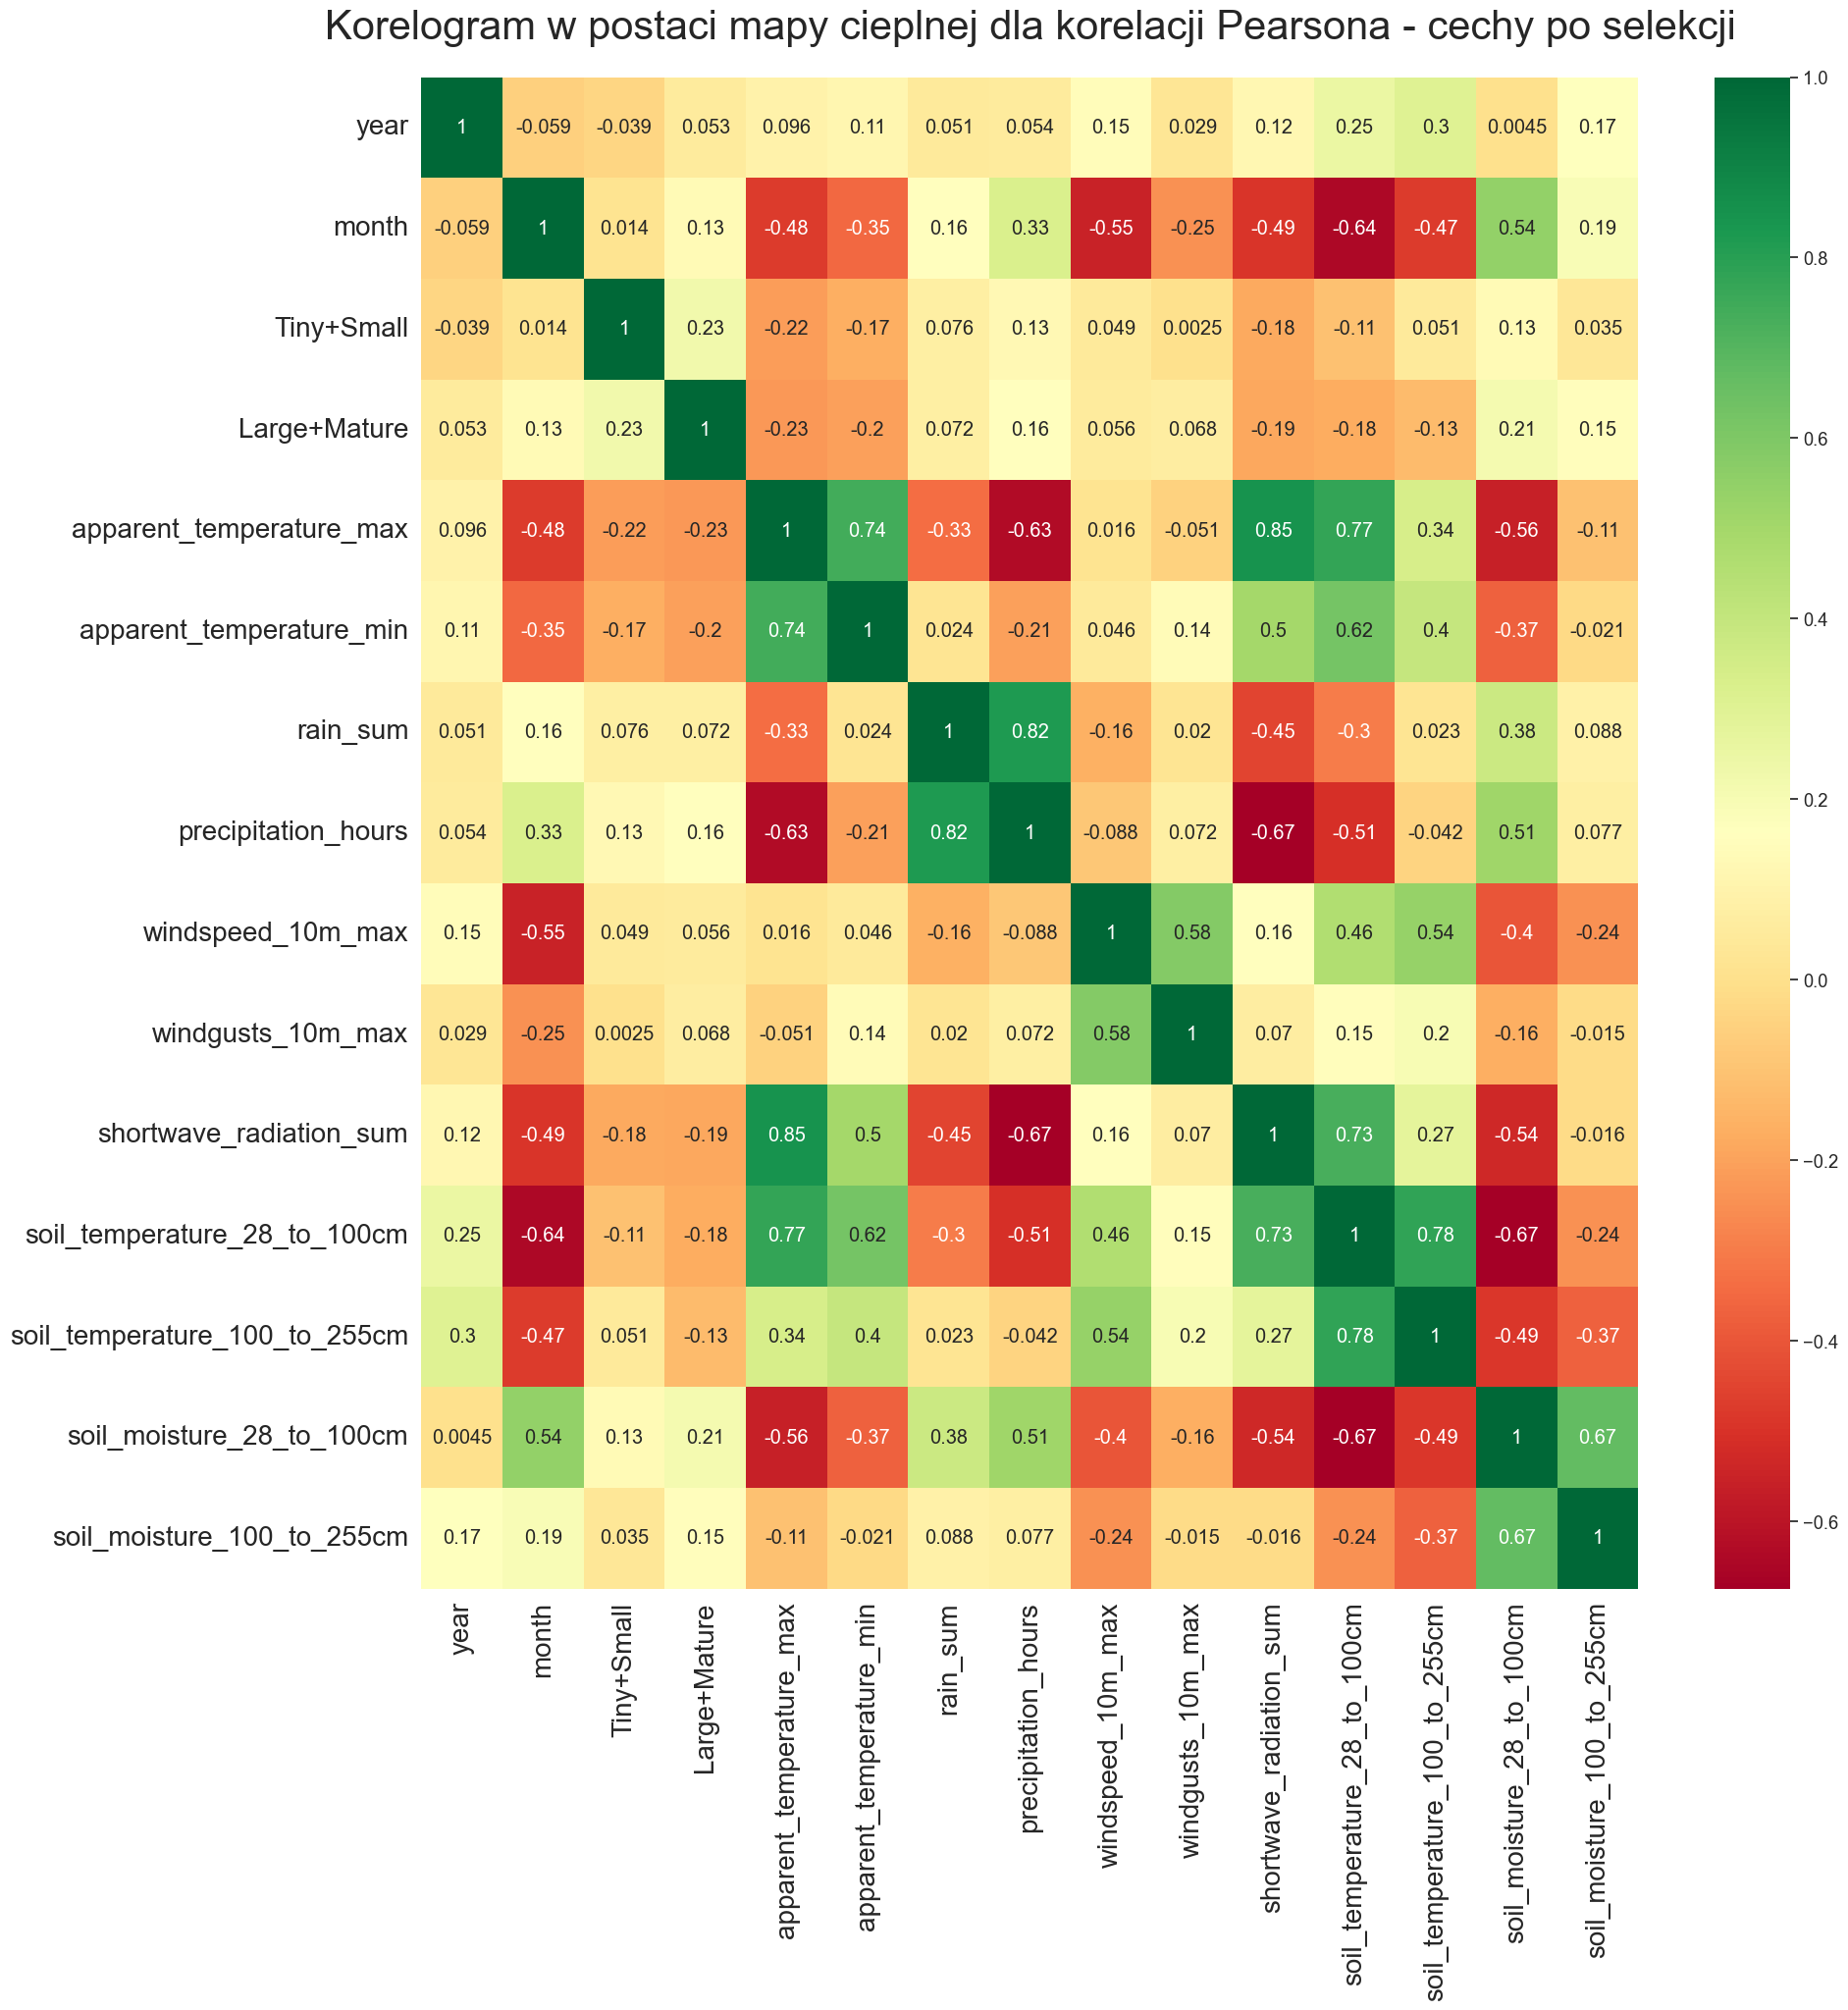

In [197]:
plot_corr_heatmap(data.drop(columns=["FarmID"]), "Korelogram w postaci mapy cieplnej dla korelacji Pearsona - cechy po selekcji")

Ile miesięcy do tyłu (ile lagów) powinienem stworzyć?

Z wiedzy dziedzinowej można stwierdzić, że powinno to być 6 lub 12 miesięcy, czyli okres równoważny kolejnym etapom wzrostu owoców na drzewach, gdzie maksimum zbiorów przypada zawsze na okres letni.

Można to też sprawdzić sumując wyniki względem całego kraju i sprawdzając wykres ACF.

In [198]:
data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,apparent_temperature_min,rain_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,36.770968,25.441935,0.429032,0.903226,10.738710,24.787097,20.136774,27.784005,26.701613,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,39.117857,28.378571,1.857143,1.535714,11.317857,25.207143,20.272143,28.965923,27.353274,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,40.496774,29.983871,1.654839,2.354839,13.103226,30.777419,20.438065,30.227554,28.187097,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,39.120000,29.943333,4.073333,4.100000,12.033333,29.463333,17.877667,29.357361,28.793472,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,37.919355,29.096774,2.603226,3.741935,11.693548,28.103226,17.486452,28.578495,28.817876,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,37.380645,27.251613,2.758065,3.709677,12.983871,29.116129,19.784194,28.419355,27.342876,0.305570,0.424620
9012,MA413,2023,4,2.0,3.0,37.903333,27.520000,2.563333,3.933333,12.423333,28.396667,20.378667,28.444028,27.731250,0.299015,0.413540
9013,MA413,2023,5,3.0,4.0,37.435484,28.312903,3.029032,4.903226,10.941935,25.816129,18.983226,28.383737,27.991801,0.301789,0.404790
9014,MA413,2023,6,1.0,1.0,33.333333,26.320000,6.823333,9.066667,12.590000,26.870000,14.725667,27.324167,27.972361,0.349479,0.399222


In [199]:
def make_date_index(df):
    df["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in df.iterrows()]
    df["Date"] = pd.to_datetime(df["Date"])
    df.index = df["Date"]
    df.drop(columns=["Date"], inplace=True)

In [200]:
make_date_index(data)

<Axes: xlabel='Date'>

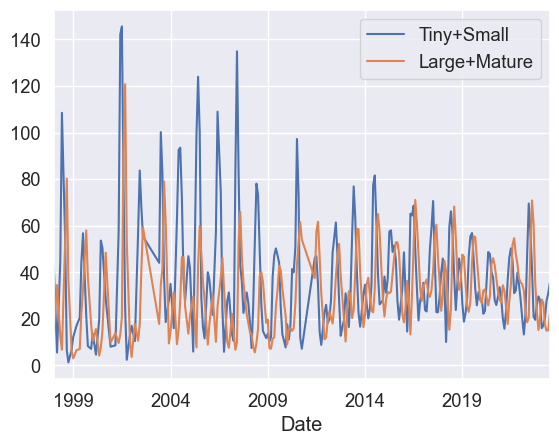

In [201]:
data.groupby("Date")[["Tiny+Small", "Large+Mature"]].mean().plot()

In [202]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

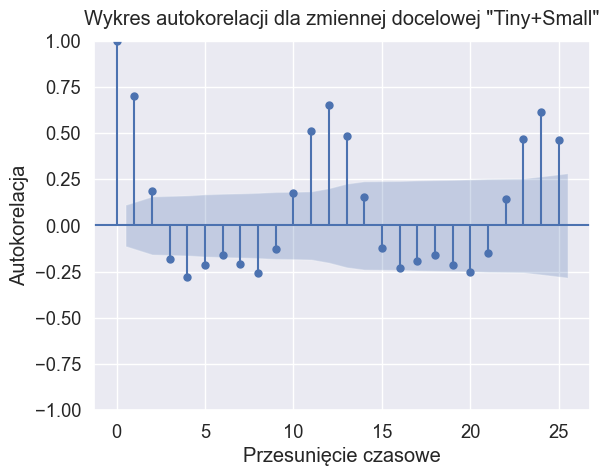

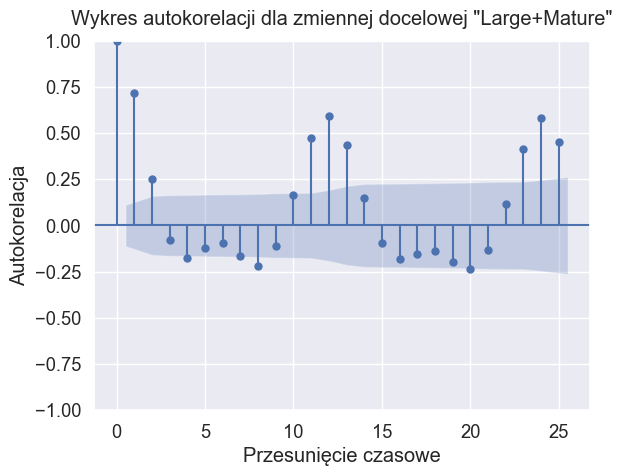

In [207]:
plot_acf(data.groupby("Date")[["Tiny+Small", "Large+Mature"]].mean()["Tiny+Small"])
plt.title('Wykres autokorelacji dla zmiennej docelowej "Tiny+Small"', x=0.5, y=1.02)
plt.xlabel("Przesunięcie czasowe")
plt.ylabel("Autokorelacja")
plt.show()
plot_acf(data.groupby("Date")[["Tiny+Small", "Large+Mature"]].mean()["Large+Mature"])
plt.title('Wykres autokorelacji dla zmiennej docelowej "Large+Mature"', x=0.5, y=1.02)
plt.xlabel("Przesunięcie czasowe")
plt.ylabel("Autokorelacja")
plt.show()

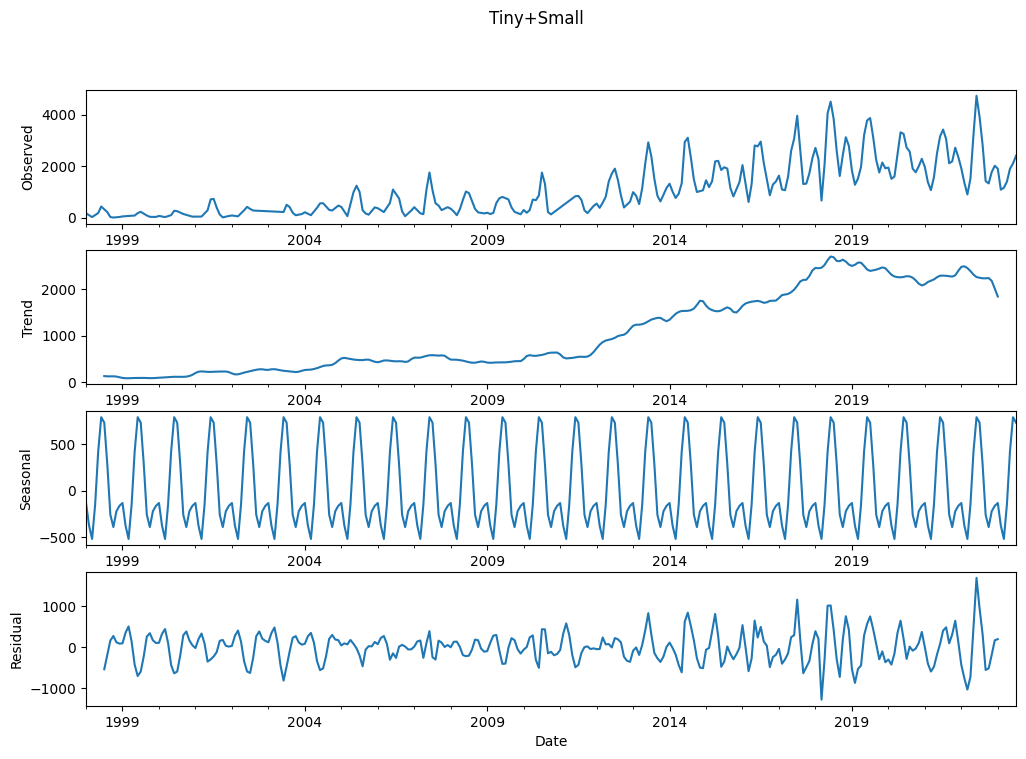

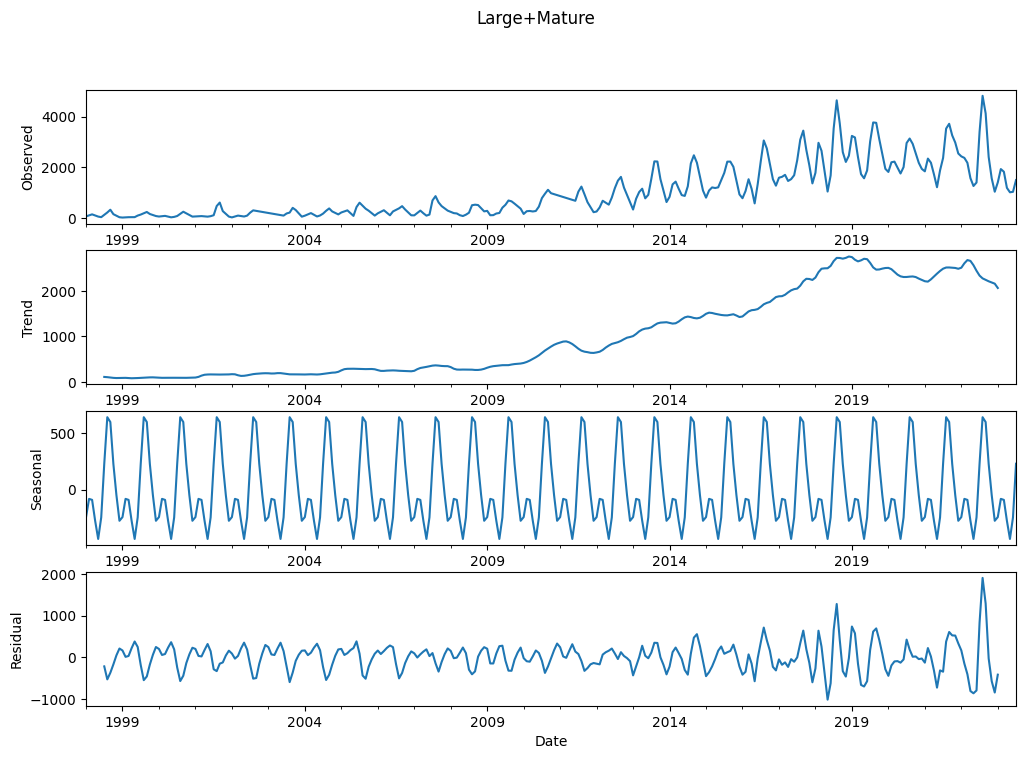

In [124]:
for column in data.groupby("Date")[["Tiny+Small", "Large+Mature"]].sum().columns:
    decomp = seasonal_decompose(data.groupby("Date")[["Tiny+Small", "Large+Mature"]].sum()[column])
    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    decomp.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    decomp.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    decomp.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomp.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')

    # Add a title to the plot
    fig.suptitle(column)

    # Show the plot
    plt.show()

In [14]:
n_lags = 12

data_lags = data.copy()


for column in data_lags.drop(columns=["FarmID", "year", "month"]).columns:
    for i in range(1, n_lags+1):
        data_lags['lag_' + str(column) + '_' + str(i)] = data_lags[column].shift(i)


# Step 2: Drop rows with NaN values
data_lags.dropna(inplace=True)

C:\Users\BC127735\AppData\Local\Temp\ipykernel_15008\3262555584.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_lags['lag_' + str(column) + '_' + str(i)] = data_lags[column].shift(i)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_15008\3262555584.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_lags['lag_' + str(column) + '_' + str(i)] = data_lags[column].shift(i)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_15008\3262555584.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

In [15]:
data_lags

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,apparent_temperature_min,rain_sum,precipitation_hours,windspeed_10m_max,...,lag_soil_moisture_100_to_255cm_3,lag_soil_moisture_100_to_255cm_4,lag_soil_moisture_100_to_255cm_5,lag_soil_moisture_100_to_255cm_6,lag_soil_moisture_100_to_255cm_7,lag_soil_moisture_100_to_255cm_8,lag_soil_moisture_100_to_255cm_9,lag_soil_moisture_100_to_255cm_10,lag_soil_moisture_100_to_255cm_11,lag_soil_moisture_100_to_255cm_12
12,AG10,1999,1,8.0,5.0,35.741935,27.183871,0.890323,2.741935,11.651613,...,0.346444,0.344000,0.344887,0.345595,0.347368,0.349663,0.352946,0.357526,0.362451,0.367218
13,AG10,1999,2,6.5,11.0,36.375000,26.371429,2.792857,3.571429,11.271429,...,0.355021,0.346444,0.344000,0.344887,0.345595,0.347368,0.349663,0.352946,0.357526,0.362451
14,AG10,1999,3,5.0,17.0,37.390323,27.803226,2.367742,3.645161,12.219355,...,0.355773,0.355021,0.346444,0.344000,0.344887,0.345595,0.347368,0.349663,0.352946,0.357526
15,AG10,1999,4,18.0,14.0,37.423333,27.980000,3.800000,3.433333,11.960000,...,0.353925,0.355773,0.355021,0.346444,0.344000,0.344887,0.345595,0.347368,0.349663,0.352946
16,AG10,1999,5,31.0,11.0,36.832258,27.774194,2.822581,4.193548,11.648387,...,0.351115,0.353925,0.355773,0.355021,0.346444,0.344000,0.344887,0.345595,0.347368,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,37.380645,27.251613,2.758065,3.709677,12.983871,...,0.471591,0.485847,0.490792,0.459283,0.412464,0.402919,0.396256,0.399665,0.406600,0.415659
9012,MA413,2023,4,2.0,3.0,37.903333,27.520000,2.563333,3.933333,12.423333,...,0.453578,0.471591,0.485847,0.490792,0.459283,0.412464,0.402919,0.396256,0.399665,0.406600
9013,MA413,2023,5,3.0,4.0,37.435484,28.312903,3.029032,4.903226,10.941935,...,0.437628,0.453578,0.471591,0.485847,0.490792,0.459283,0.412464,0.402919,0.396256,0.399665
9014,MA413,2023,6,1.0,1.0,33.333333,26.320000,6.823333,9.066667,12.590000,...,0.424620,0.437628,0.453578,0.471591,0.485847,0.490792,0.459283,0.412464,0.402919,0.396256


In [16]:
targets = ["Tiny+Small", "Large+Mature"]
processed_targets = []
steps_ahead = 6
for target in targets:
    for i in range(1, steps_ahead+1):
        data_lags[f"{target}_+{i}"] = data_lags.groupby("FarmID")[target].shift(-i)
        processed_targets.append(f"{target}_+{i}")

data_lags = data_lags.dropna()

In [17]:
data_lags

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,apparent_temperature_min,rain_sum,precipitation_hours,windspeed_10m_max,...,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6
12,AG10,1999,1,8.0,5.0,35.741935,27.183871,0.890323,2.741935,11.651613,...,18.0,31.0,78.0,70.000000,11.0,17.0,14.0,11.0,36.0,69.000000
13,AG10,1999,2,6.5,11.0,36.375000,26.371429,2.792857,3.571429,11.271429,...,31.0,78.0,70.0,57.500000,17.0,14.0,11.0,36.0,69.0,86.500000
14,AG10,1999,3,5.0,17.0,37.390323,27.803226,2.367742,3.645161,12.219355,...,78.0,70.0,57.5,45.000000,14.0,11.0,36.0,69.0,86.5,104.000000
15,AG10,1999,4,18.0,14.0,37.423333,27.980000,3.800000,3.433333,11.960000,...,70.0,57.5,45.0,10.000000,11.0,36.0,69.0,86.5,104.0,72.000000
16,AG10,1999,5,31.0,11.0,36.832258,27.774194,2.822581,4.193548,11.648387,...,57.5,45.0,10.0,9.333333,36.0,69.0,86.5,104.0,72.0,53.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9005,MA413,2022,9,4.0,45.0,32.260000,25.243333,7.030000,13.200000,11.606667,...,15.0,6.0,1.0,2.000000,37.0,17.0,10.0,11.0,11.0,11.000000
9006,MA413,2022,10,2.0,37.0,34.119355,25.803226,4.745161,9.290323,9.190323,...,6.0,1.0,2.0,2.000000,17.0,10.0,11.0,11.0,11.0,3.000000
9007,MA413,2022,11,5.0,17.0,34.520000,25.436667,1.643333,4.833333,9.440000,...,1.0,2.0,2.0,3.000000,10.0,11.0,11.0,11.0,3.0,4.000000
9008,MA413,2022,12,15.0,10.0,34.325806,23.629032,0.596774,1.516129,9.706452,...,2.0,2.0,3.0,1.000000,11.0,11.0,11.0,3.0,4.0,1.000000


In [125]:
data_lags.to_csv("../Data/prepared_data_FE.csv")

In [18]:
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.metrics import mean_squared_error

In [19]:
n_splits = 5
data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "test": pd.DataFrame()} for i in range(1, n_splits+1)}

# Tworzenie TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

for category in data_lags["FarmID"].unique():
    for i, (train_index, test_index) in enumerate(tscv.split(data_lags[data_lags["FarmID"] == category].index.values)):
        train_data = data_lags[data_lags["FarmID"] == category].iloc[train_index]
        test_data = data_lags[data_lags["FarmID"] == category].iloc[test_index]

        data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
        data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)

C:\Users\BC127735\AppData\Local\Temp\ipykernel_15008\2563356423.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_15008\2563356423.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)


In [20]:
train, test = data_dict["iter_5"]["train"], data_dict["iter_5"]["test"]

In [25]:
len(test)/len(data_lags)

0.16333178222429037

In [21]:
train

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,apparent_temperature_min,rain_sum,precipitation_hours,windspeed_10m_max,...,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6
0,AG10,1999,1,8.0,5.0,35.741935,27.183871,0.890323,2.741935,11.651613,...,18.0,31.0,78.0,70.000000,11.0,17.0,14.0,11.0,36.0,69.000000
1,AG10,1999,2,6.5,11.0,36.375000,26.371429,2.792857,3.571429,11.271429,...,31.0,78.0,70.0,57.500000,17.0,14.0,11.0,36.0,69.0,86.500000
2,AG10,1999,3,5.0,17.0,37.390323,27.803226,2.367742,3.645161,12.219355,...,78.0,70.0,57.5,45.000000,14.0,11.0,36.0,69.0,86.5,104.000000
3,AG10,1999,4,18.0,14.0,37.423333,27.980000,3.800000,3.433333,11.960000,...,70.0,57.5,45.0,10.000000,11.0,36.0,69.0,86.5,104.0,72.000000
4,AG10,1999,5,31.0,11.0,36.832258,27.774194,2.822581,4.193548,11.648387,...,57.5,45.0,10.0,9.333333,36.0,69.0,86.5,104.0,72.0,53.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,MA413,2021,12,18.0,22.0,36.051613,26.212903,0.241935,0.483871,9.770968,...,8.0,2.0,11.0,27.000000,16.0,11.0,24.0,27.0,18.0,8.000000
7188,MA413,2022,1,12.0,16.0,35.280645,24.335484,0.022581,0.193548,10.512903,...,2.0,11.0,27.0,42.000000,11.0,24.0,27.0,18.0,8.0,14.000000
7189,MA413,2022,2,14.0,11.0,37.707143,26.942857,0.625000,1.392857,12.721429,...,11.0,27.0,42.0,10.000000,24.0,27.0,18.0,8.0,14.0,36.000000
7190,MA413,2022,3,8.0,24.0,38.119355,27.774194,2.606452,4.193548,12.232258,...,27.0,42.0,10.0,4.000000,27.0,18.0,8.0,14.0,36.0,45.000000


In [29]:
test

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,apparent_temperature_min,rain_sum,precipitation_hours,windspeed_10m_max,...,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6
0,AG10,2019,2,7.0,40.0,38.300000,28.667857,1.775000,2.821429,11.867857,...,44.0,45.0,46.0,25.0,44.0,26.0,50.0,42.0,137.0,56.0
1,AG10,2019,3,11.0,44.0,39.464516,29.067742,2.203226,2.903226,12.796774,...,45.0,46.0,25.0,6.0,26.0,50.0,42.0,137.0,56.0,22.0
2,AG10,2019,4,30.0,26.0,38.716667,28.993333,4.720000,5.000000,12.013333,...,46.0,25.0,6.0,10.0,50.0,42.0,137.0,56.0,22.0,13.0
3,AG10,2019,5,44.0,50.0,36.896774,28.670968,4.519355,5.129032,11.145161,...,25.0,6.0,10.0,37.0,42.0,137.0,56.0,22.0,13.0,17.0
4,AG10,2019,6,45.0,42.0,33.663333,26.833333,2.716667,5.600000,11.380000,...,6.0,10.0,37.0,7.0,137.0,56.0,22.0,13.0,17.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,MA413,2022,9,4.0,45.0,32.260000,25.243333,7.030000,13.200000,11.606667,...,15.0,6.0,1.0,2.0,37.0,17.0,10.0,11.0,11.0,11.0
1400,MA413,2022,10,2.0,37.0,34.119355,25.803226,4.745161,9.290323,9.190323,...,6.0,1.0,2.0,2.0,17.0,10.0,11.0,11.0,11.0,3.0
1401,MA413,2022,11,5.0,17.0,34.520000,25.436667,1.643333,4.833333,9.440000,...,1.0,2.0,2.0,3.0,10.0,11.0,11.0,11.0,3.0,4.0
1402,MA413,2022,12,15.0,10.0,34.325806,23.629032,0.596774,1.516129,9.706452,...,2.0,2.0,3.0,1.0,11.0,11.0,11.0,3.0,4.0,1.0


In [42]:
targets = ["Tiny+Small_+1", "Large+Mature_+1", "Tiny+Small_+2", "Large+Mature_+2", "Tiny+Small_+3", "Large+Mature_+3",
"Tiny+Small_+4", "Large+Mature_+4", "Tiny+Small_+5", "Large+Mature_+5", "Tiny+Small_+6", "Large+Mature_+6"]
Xtr = train.drop(columns=["FarmID"] + targets)
ytr = train[targets]

Xtest = test.drop(columns=["FarmID"] + targets)
ytest = test[targets]

In [58]:
targets = ["Tiny+Small_+1", "Large+Mature_+1", "Tiny+Small_+2", "Large+Mature_+2", "Tiny+Small_+3", "Large+Mature_+3",
"Tiny+Small_+4", "Large+Mature_+4", "Tiny+Small_+5", "Large+Mature_+5", "Tiny+Small_+6", "Large+Mature_+6"]
X = data_lags.drop(columns=["FarmID"] + targets)
y = data_lags[targets]

### RFECV with random forest

In [59]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

rfr = RandomForestRegressor()
select = RFECV(rfr, step=1, cv=5, verbose=1)
select = select.fit(X, y)

print("Feature ranking: ", select.ranking_)
# visualize the selected features:
# mask = select.get_support()
# plt.matshow(mask.reshape(1, -1), cmap='gray_r')

Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
F

In [77]:
print(select.estimator_)
print(select.cv_results_)
print(select.n_features_)
print(select.ranking_)
print(select.support_)
print(list(compress(list(X.columns), select.support_)))

RandomForestRegressor()
{'mean_test_score': array([-0.32415214, -0.08764045,  0.10583518,  0.17113371,  0.20422965,
        0.23484976,  0.25550976,  0.27107739,  0.27803849,  0.29168581,
        0.29748347,  0.30454225,  0.30139625,  0.30518696,  0.30859261,
        0.30868427,  0.3145755 ,  0.31564517,  0.3158095 ,  0.31689287,
        0.32135661,  0.31963944,  0.32335084,  0.32281567,  0.32395074,
        0.32132765,  0.32720298,  0.32679465,  0.32554523,  0.32547006,
        0.32635882,  0.32749607,  0.3280019 ,  0.3280176 ,  0.32627622,
        0.32706661,  0.32652627,  0.32377923,  0.32736208,  0.32898619,
        0.32429182,  0.32833695,  0.3295897 ,  0.32834716,  0.32711235,
        0.33127668,  0.32743247,  0.32807017,  0.33044654,  0.33089742,
        0.33069293,  0.33108762,  0.32928154,  0.33097532,  0.33244394,
        0.33049129,  0.33013209,  0.3319881 ,  0.32782696,  0.33030695,
        0.32774401,  0.33130063,  0.33126175,  0.33128011,  0.33037791,
        0.33042061, 

In [128]:
pd.DataFrame({"column": list(X.columns), "ranking": select.ranking_})

,column,ranking
0,year,35
1,month,23
2,Tiny+Small,1
3,Large+Mature,1
4,apparent_temperature_max,1
...,...,...
166,lag_soil_moisture_100_to_255cm_8,115
167,lag_soil_moisture_100_to_255cm_9,116
168,lag_soil_moisture_100_to_255cm_10,94
169,lag_soil_moisture_100_to_255cm_11,117


In [85]:
pd.DataFrame({"column": list(X.columns), "ranking": select.ranking_}).to_csv("./RFECV_results/ranking.csv")

In [80]:
pd.DataFrame(select.cv_results_).to_csv("./RFECV_results/cv_results.csv")

In [87]:
pd.DataFrame(list(compress(list(X.columns), select.support_))).to_csv("./RFECV_results/best_features.csv")

([], [])

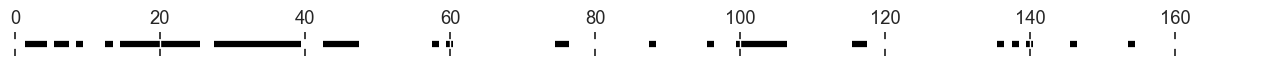

In [213]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.yticks([])

In [129]:
data_best = data_lags[["FarmID", "year", "month"] + list(compress(list(X.columns), select.support_)) + targets]
data_best

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,Tiny+Small_+2,Large+Mature_+2,Tiny+Small_+3,Large+Mature_+3,Tiny+Small_+4,Large+Mature_+4,Tiny+Small_+5,Large+Mature_+5,Tiny+Small_+6,Large+Mature_+6
12,AG10,1999,1,8.0,5.0,35.741935,0.890323,2.741935,24.187097,0.375906,...,5.0,17.0,18.0,14.0,31.0,11.0,78.0,36.0,70.000000,69.000000
13,AG10,1999,2,6.5,11.0,36.375000,2.792857,3.571429,25.178571,0.351524,...,18.0,14.0,31.0,11.0,78.0,36.0,70.0,69.0,57.500000,86.500000
14,AG10,1999,3,5.0,17.0,37.390323,2.367742,3.645161,29.335484,0.346919,...,31.0,11.0,78.0,36.0,70.0,69.0,57.5,86.5,45.000000,104.000000
15,AG10,1999,4,18.0,14.0,37.423333,3.800000,3.433333,29.006667,0.337085,...,78.0,36.0,70.0,69.0,57.5,86.5,45.0,104.0,10.000000,72.000000
16,AG10,1999,5,31.0,11.0,36.832258,2.822581,4.193548,27.741935,0.333712,...,70.0,69.0,57.5,86.5,45.0,104.0,10.0,72.0,9.333333,53.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9005,MA413,2022,9,4.0,45.0,32.260000,7.030000,13.200000,26.163333,0.493833,...,5.0,17.0,15.0,10.0,6.0,11.0,1.0,11.0,2.000000,11.000000
9006,MA413,2022,10,2.0,37.0,34.119355,4.745161,9.290323,25.064516,0.489003,...,15.0,10.0,6.0,11.0,1.0,11.0,2.0,11.0,2.000000,3.000000
9007,MA413,2022,11,5.0,17.0,34.520000,1.643333,4.833333,25.740000,0.430129,...,6.0,11.0,1.0,11.0,2.0,11.0,2.0,3.0,3.000000,4.000000
9008,MA413,2022,12,15.0,10.0,34.325806,0.596774,1.516129,24.935484,0.381405,...,1.0,11.0,2.0,11.0,2.0,3.0,3.0,4.0,1.000000,1.000000


In [130]:
data_best.to_csv("../Data/prepared_data_FE_FS.csv")

In [208]:
corrmat = data_best.corr()
top_corr_features = corrmat.index
corrmat[targets]

,Tiny+Small_+1,Large+Mature_+1,Tiny+Small_+2,Large+Mature_+2,Tiny+Small_+3,Large+Mature_+3,Tiny+Small_+4,Large+Mature_+4,Tiny+Small_+5,Large+Mature_+5,Tiny+Small_+6,Large+Mature_+6
year,-0.027055,0.085774,-0.027784,0.082988,-0.027171,0.077542,-0.028438,0.073992,-0.034758,0.072053,-0.041903,0.069463
month,-0.023136,0.052415,-0.108919,0.027561,-0.223413,0.004208,-0.256367,-0.079484,-0.164970,-0.210871,0.007315,-0.284465
Tiny+Small,0.671906,0.549089,0.274452,0.713786,0.088169,0.566614,0.058818,0.289867,0.090784,0.104275,0.110242,0.055121
Large+Mature,0.021559,0.758596,-0.005575,0.407411,0.037474,0.165805,0.065624,0.102927,0.055297,0.125812,0.047486,0.146173
apparent_temperature_max,-0.038785,-0.304258,0.139994,-0.250262,0.224901,-0.083651,0.202152,0.112260,0.124627,0.225819,0.070547,0.222475
...,...,...,...,...,...,...,...,...,...,...,...,...
Large+Mature_+4,0.568857,0.168531,0.715270,0.411684,0.550235,0.762381,0.229731,1.000000,0.028197,0.762648,-0.001512,0.414187
Tiny+Small_+5,0.059453,0.065901,0.090331,0.037507,0.279590,-0.003007,0.675263,0.028197,1.000000,0.231547,0.674803,0.551548
Large+Mature_+5,0.292243,0.104631,0.569249,0.169315,0.715232,0.412948,0.551225,0.762648,0.231547,1.000000,0.029503,0.763149
Tiny+Small_+6,0.091659,0.056932,0.060502,0.067577,0.090730,0.039298,0.278336,-0.001512,0.674803,0.029503,1.000000,0.232253


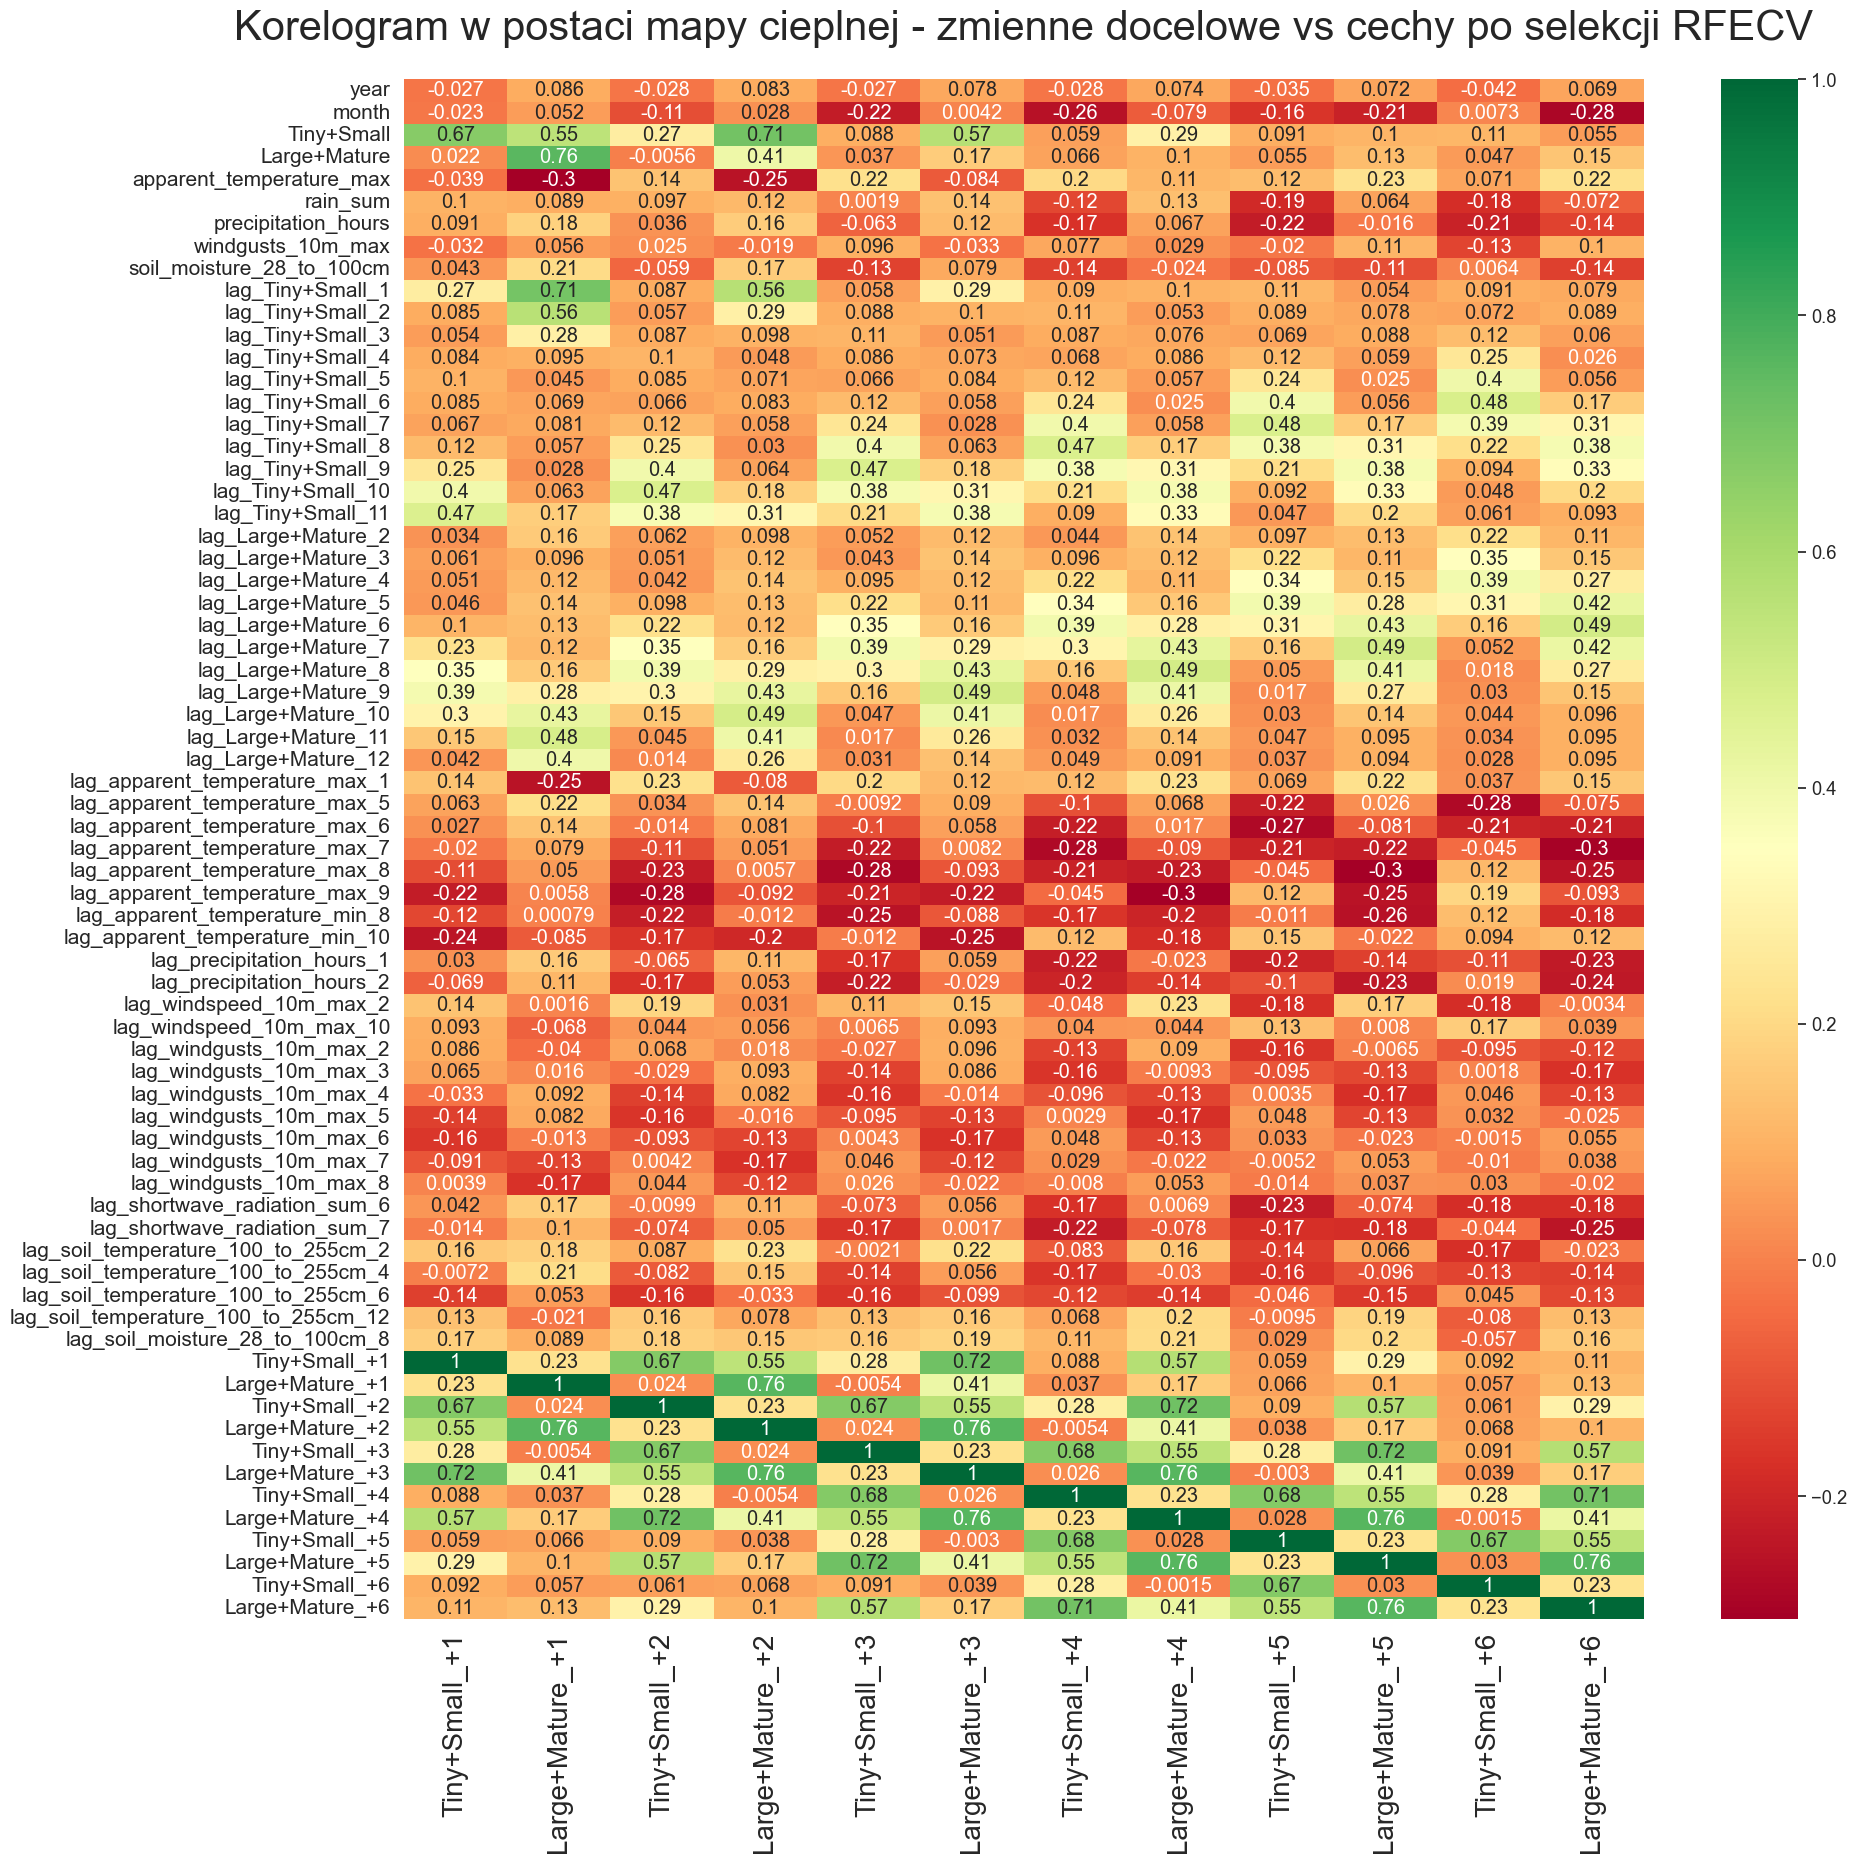

In [214]:
plt.figure(figsize=(20,20))
#plot heat map
plt.title("Korelogram w postaci mapy cieplnej - zmienne docelowe vs cechy po selekcji RFECV", fontsize = 30, x=0.5, y=1.02)
plt.xlabel("Zmienne docelowe")
plt.ylabel("Cechy po selekcji")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
sns.set(font_scale=1.2) # font size 2
g=sns.heatmap(corrmat[targets],annot=True,cmap="RdYlGn")